In [2]:
# import suite2p
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
plt.style.use(['dark_background'])

# plt.rcParams['text.usetex'] = False


In [103]:
def spiral_scan(samples_per_spiral = 128, tightness = 1, n_spirals = 16, extent = 4):
    theta = np.linspace(0, extent*np.pi, samples_per_spiral + 1)[1:]
    r = theta ** (1/tightness)
    r = r / r.max()
    xy = np.empty((samples_per_spiral*n_spirals, 2))

    for i in range(n_spirals):
        xy[samples_per_spiral*i : samples_per_spiral*(i+1),0] = r * np.cos(theta + 2*np.pi/n_spirals*i)
        xy[samples_per_spiral*i : samples_per_spiral*(i+1),1] = r * np.sin(theta + 2*np.pi/n_spirals*i)
    
    return xy

In [117]:
def rectangular_scan(samples_per_line = 128, lines_per_frame = 32):
    x,y  = np.meshgrid(np.linspace(-1,1,samples_per_line), np.linspace(1,-1,lines_per_frame))
    x[1::2,:] = -x[1::2,:] #bidi scan
    return np.stack((x.flatten(), y.flatten()), axis=1)

In [246]:
def plot_scan(xy):
    plt.figure(figsize=(25,10))

    t = np.arange(len(xy))
    ax1 = plt.subplot(1,3,1)
    sc = ax1.scatter(xy[:,0],xy[:,1], c=t)
    

    ax2 = plt.subplot(2,3,2)
    plt.scatter(t, xy[:,0], c=t)
    ax3 = plt.subplot(2,3,5)
    plt.scatter(t, xy[:,1], c=t)

    ax4 = plt.subplot(3,3,3)
    plt.scatter(t, np.diff(np.concatenate((xy[:,0], xy[np.newaxis,0,0]))), c=t)

    ax5 = plt.subplot(3,3,9)
    plt.scatter(t, np.diff(np.concatenate((xy[:,1], xy[np.newaxis,0,1]))), c=t)

    ax6 = plt.subplot(3,3,6)
    plt.scatter(t, np.sqrt(np.diff(np.concatenate((xy[:,0], xy[np.newaxis,0,0]))) ** 2 + np.diff(np.concatenate((xy[:,1], xy[np.newaxis,0,1]))) ** 2), c=t)
    
    cb = plt.colorbar(sc, ax=ax1, location='left')
    cb.set_label('Sample number')
    ax3.set_xlabel('Sample number')
    ax5.set_xlabel('Sample_number')
    ax1.set_aspect(1)
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax2.set_ylabel('X')
    ax3.set_ylabel('Y')

    ax4.set_ylabel('δX')
    ax5.set_ylabel('δY')
    ax6.set_ylabel('Scan speed')

    # ax2.set_ylim(-2.1,2.1)
    # ax3.set_ylim(-2.1,2.1)
    # ax4.set_ylim(-2.1,2.1)
    # ax5.set_ylim(-2.1,2.1)
    # ax6.set_ylim(0,2.1)

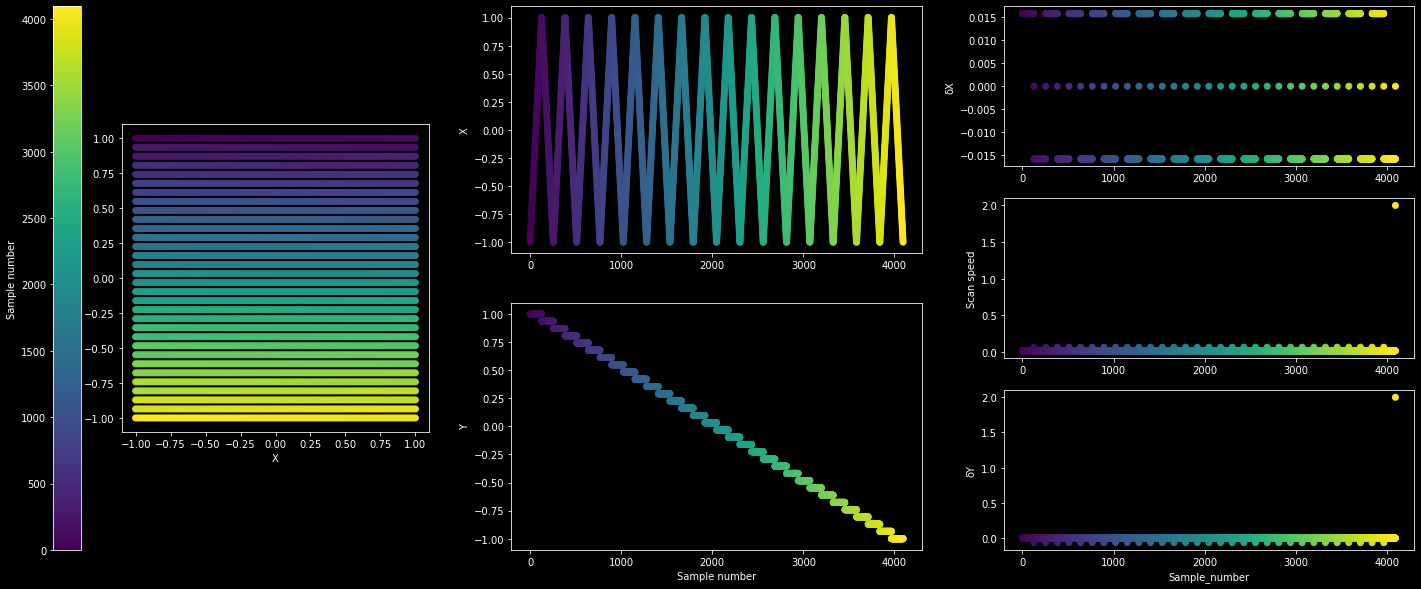

In [247]:
plot_scan(rectangular_scan())

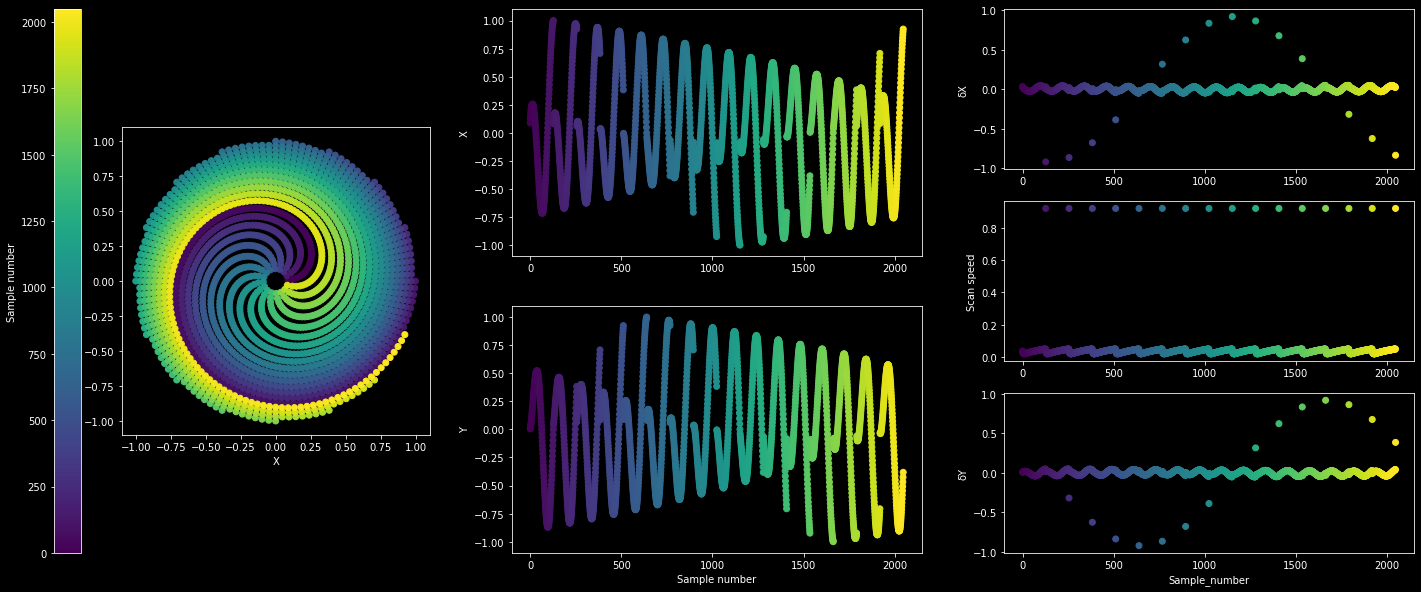

In [254]:
# plot_scan(np.concatenate((spiral_scan(tightness= 2, extent = 2),(spiral_scan(tightness= 2, extent = 2)))))
plot_scan(spiral_scan(tightness= 2, extent = 2))

[[ 8.46663398e-02 -8.67573548e-19]
 [-8.67573548e-19  8.87313403e-02]]


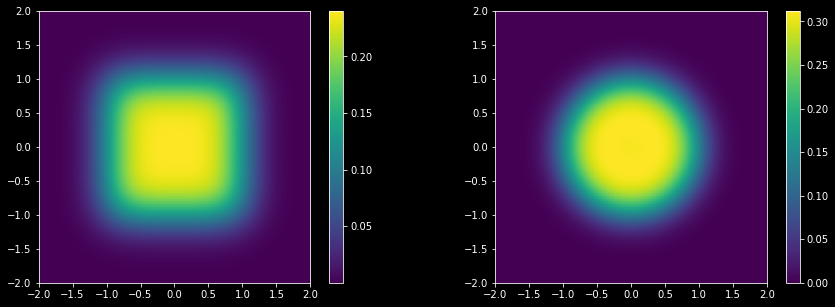

In [111]:
qX,qY = np.meshgrid(np.linspace(-2,2,100),np.linspace(-2,2,100))

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
k = stats.gaussian_kde(rectangular_scan().T, .5)
print(k.covariance)
plt.imshow(k(np.vstack((qX.flatten(), qY.flatten()))).reshape(qX.shape), extent=[-2,2,-2,2])
plt.colorbar()

plt.subplot(1,2,2)
k = stats.gaussian_kde(spiral_scan(tightness=2, extent = 2).T, .5)
plt.imshow(k(np.vstack((qX.flatten(), qY.flatten()))).reshape(qX.shape), extent=[-2,2,-2,2])

plt.colorbar()


In [252]:
def toroidal_scan(samples_per_ring = 128, n_rings = 16, r_inner = .5, r_outer=1.5):
    theta1 = np.linspace(0, 2*np.pi, samples_per_ring+1)[:-1]
    # xy = np.empty((samples_per_ring*n_rings, 2))

    xy = np.tile(np.stack((r_inner * np.cos(theta1), r_inner * np.sin(theta1)), axis=1),(n_rings,1))
    print(xy.shape)
    
    theta2 = np.linspace(0, 2*np.pi, samples_per_ring * n_rings)
    xy = xy + np.stack((r_outer * np.cos(theta2), r_outer * np.sin(theta2)), axis=1)
    # for i in range(n_spirals):
    #     xy[samples_per_ring*i : samples_per_ring*(i+1),0] = r_inner * np.cos(theta1) + r_outer * np.cos(theta2)
    #     xy[samples_per_ring*i : samples_per_ring*(i+1),1] = r_inner * np.sin(theta1) + r_outer * np.sin(theta2)
    
    return xy

(4096, 2)


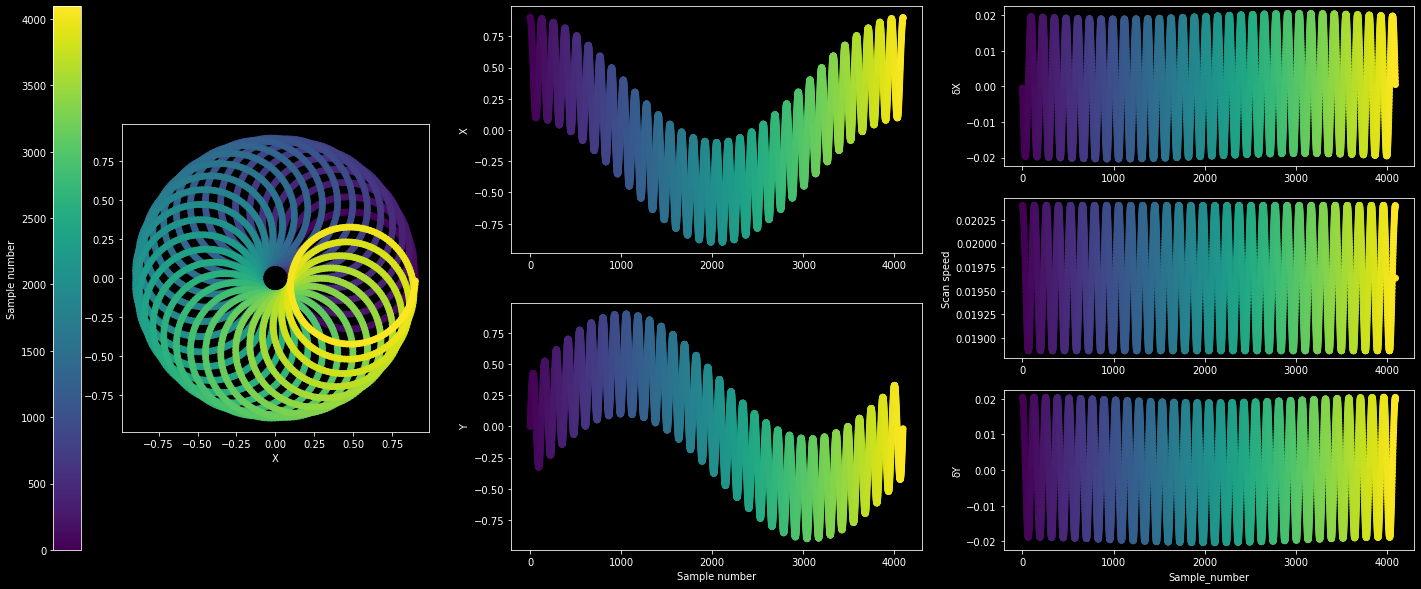

In [253]:
plot_scan(toroidal_scan(r_outer = .5, r_inner=.4, samples_per_ring=128, n_rings=32))
# plt.plot(np.tile(np.linspace(0, 2*np.pi,128), 16))

(2048, 2)
[[ 6.34617434e-02 -3.49826014e-18]
 [-3.49826014e-18  6.15373336e-02]]


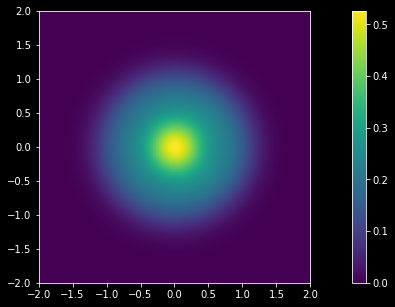

In [245]:
qX,qY = np.meshgrid(np.linspace(-2,2,100),np.linspace(-2,2,100))

plt.figure(figsize=(15,5))
k = stats.gaussian_kde(toroidal_scan(r_outer = .5, r_inner=.5, samples_per_ring=32, n_rings=64).T, .5)
print(k.covariance)
plt.imshow(k(np.vstack((qX.flatten(), qY.flatten()))).reshape(qX.shape), extent=[-2,2,-2,2])
plt.colorbar()

In [3]:
def reso_scan_mask(line_rate, sample_rate, spatial_fill_fraction, pixels_per_line):
    pixel_boundaries = np.linspace(-spatial_fill_fraction,spatial_fill_fraction,pixels_per_line+1)
    pixel_boundaries_time = np.arcsin(pixel_boundaries) / (np.pi*line_rate)
    pixel_boundaries_samples = pixel_boundaries_time * sample_rate
    pixel_boundaries_samples = np.round(pixel_boundaries_samples)
    return np.diff(pixel_boundaries_samples)


In [1]:
import suite2p
img = suite2p.io.tiff.ScanImageTiffReader(r"C:\Users\zfj\data\petrilab\2p functional imaging\20230908\20230908Dcc3-lambda-750-stack_00001.tif")

In [64]:
print(img.metadata())
# SI.hRoiManager.imagingFovUm = [-258.515 -258.515;258.515 -258.515;258.515 258.515;-258.515 258.515]

# SI.hRoiManager.linePeriod = 6.30829e-05
# SI.hScan2D.fillFractionSpatial = 0.9
# SI.hScan2D.mask = ...
# SI.hRoiManager.pixelsPerLine = 1024
# SI.hScan2D.uniformSampling = true
# SI.hScan2D.fillFractionTemporal = 0.712867

SI.LINE_FORMAT_VERSION = 1
SI.PREMIUM = true
SI.TIFF_FORMAT_VERSION = 4
SI.VERSION_COMMIT = '3baa4b74bec9938bfd4c7403bddbe78f2a0ccd93'
SI.VERSION_MAJOR = 2021
SI.VERSION_MINOR = 0
SI.VERSION_UPDATE = 0
SI.acqState = 'grab'
SI.acqsPerLoop = 1
SI.errorMsg = ''
SI.extTrigEnable = false
SI.fieldCurvatureRxs = []
SI.fieldCurvatureRys = []
SI.fieldCurvatureTilt = 0
SI.fieldCurvatureTip = 0
SI.fieldCurvatureZs = []
SI.hBeams.enablePowerBox = false
SI.hBeams.errorMsg = ''
SI.hBeams.flybackBlanking = true
SI.hBeams.interlaceDecimation = 1
SI.hBeams.interlaceOffset = 0
SI.hBeams.lengthConstants = Inf
SI.hBeams.name = 'SI Beams'
SI.hBeams.powerBoxEndFrame = Inf
SI.hBeams.powerBoxStartFrame = 1
SI.hBeams.powerBoxes.rect = [0.25 0.25 0.5 0.5]
SI.hBeams.powerBoxes.powers = NaN
SI.hBeams.powerBoxes.name = ''
SI.hBeams.powerBoxes.oddLines = true
SI.hBeams.powerBoxes.evenLines = true
SI.hBeams.powerBoxes.mask = []
SI.hBeams.powerFractionLimits = 1
SI.hBeams.powerFractions = 0.32
SI.hBeams.powers = 32
S

In [67]:
img.shape()

[7080, 1024, 514]

7.0

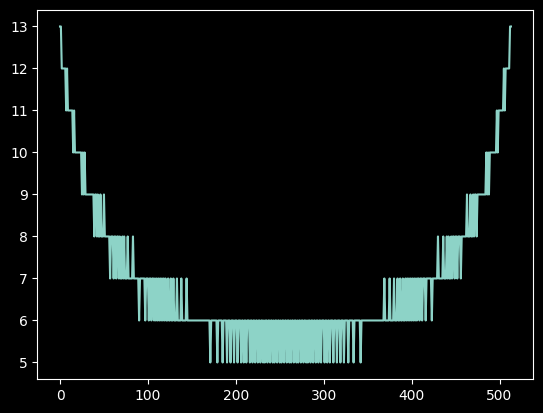

In [4]:
m = reso_scan_mask(1/(6.30829e-05), 80e6, .9, 514)
plt.plot(m)
m.mean()

In [5]:
from scipy.interpolate import interp1d

In [6]:
red = img.data().reshape((-1,10,2,1024,514))[:,:,1].mean(axis=1)

In [92]:
red.shape

(354, 1024, 514)

In [7]:
# plt.imshow(red[300])
img2 = np.empty((354,1024,1024))
xi = np.linspace(-0.712867, 0.712867, 1024)

for z in range(354):
    for y in range(1024):
        img2[z,y] = interp1d(np.sin(np.linspace(-np.pi/2 * 0.712867, np.pi/2 * 0.712867, 514)), red[z][y])(xi)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 1023.5, 1023.5, -0.5)

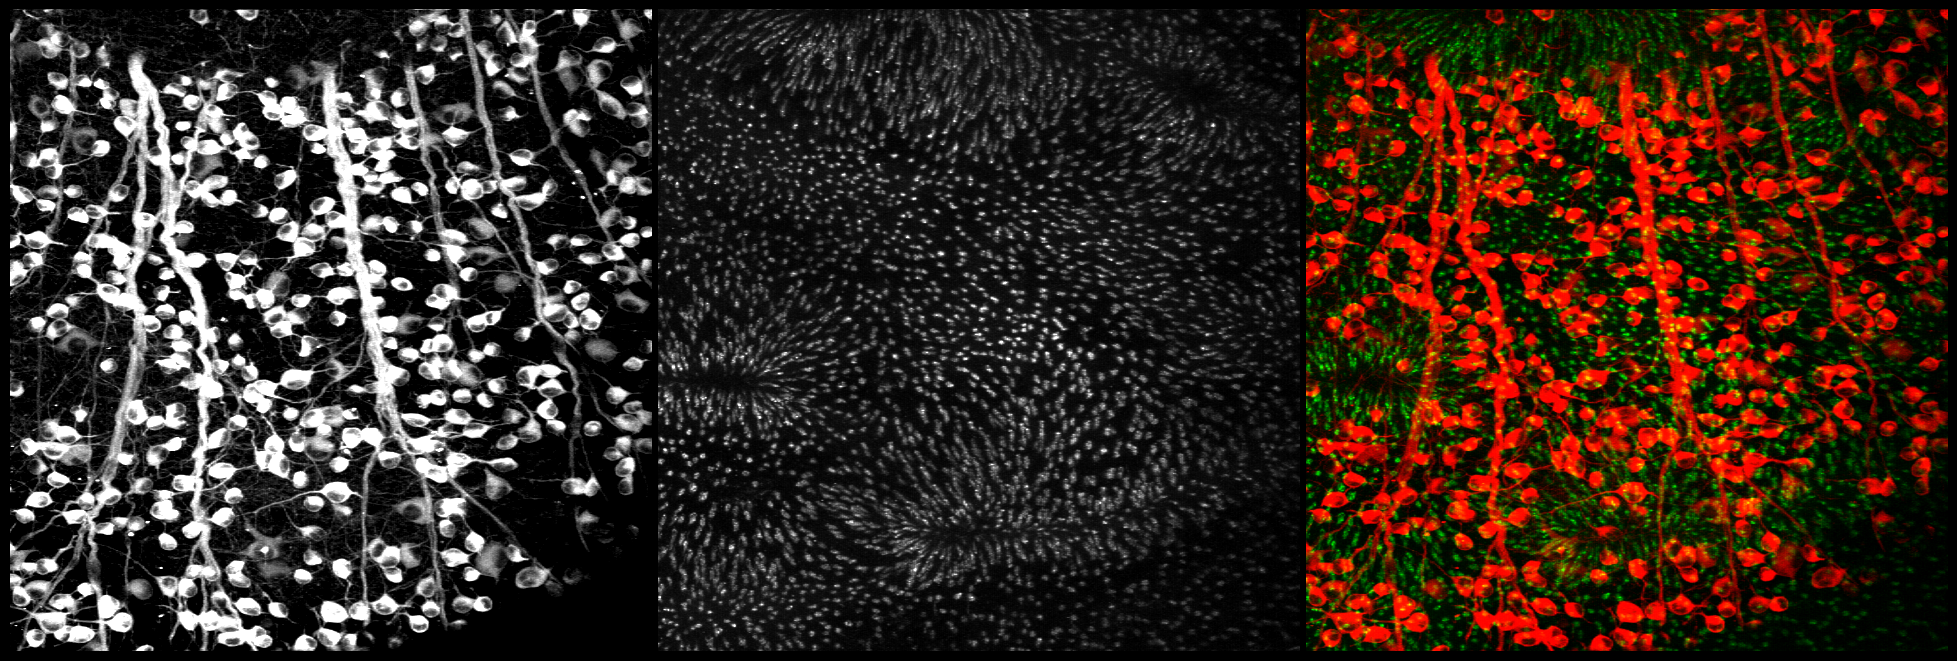

In [8]:
# plt.figure(figsize=(25,12))
# plt.subplot(1,2,1)
# plt.imshow(img2[288:].max(axis=0), cmap='gray')
# plt.subplot(1,2,2)
# plt.imshow(img2[23:132].max(axis=0), cmap='gray')
rgcs = (img2[288:].max(axis=0) - 500) / 1700
cones = (img2[23:132].max(axis=0) - 100) / 1500

fig = plt.figure(figsize=(25,20))
plt.subplots_adjust(wspace=.01)

fig.add_subplot(1,3,1)
plt.imshow(rgcs, cmap='gray')
plt.clim(0,1)
plt.axis('off')
fig.add_subplot(1,3,2)
plt.imshow(cones, cmap='gray')
plt.clim(0,1)
plt.axis('off')
fig.add_subplot(1,3,3)
plt.imshow(np.stack((rgcs, cones, np.zeros_like(cones)), axis=-1))
# plt.imshow(np.stack((rgcs, cones, cones), axis=-1))
# plt.imshow(cones)
# plt.clim(0,1)
# plt.colorbar()

plt.axis('off')